In [ ]:
%pip install emoji

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import re
import time
import emoji
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tqdm.auto import tqdm
import tensorflow as tf
#%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
TRAIN_DATA_PATH = '/content/train.csv'
TEST_DATA_PATH = '/content/test.csv'
SAVED_MODEL_PATH = '/content/model.keras'
VOCAB_SIZE = 10000  # Vocabulary size for tokenizer
EMBEDDING_DIM = 100  # Embedding dimension for LSTM
MAX_LEN = 128  # Maximum sequence length
BATCH_SIZE = 32
NUM_CLASSES = 2
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5

print("Configuration Loaded Successfully!")

Configuration Loaded Successfully!


In [ ]:
def clean_text(text):
    """Cleans text by removing emojis, special characters, lowercasing, stemming, and lemmatizing."""
    text = emoji.replace_emoji(text, replace="")
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = " ".join(text.split())
    words = text.split()
    words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words if word.lower() not in stop_words]
    return " ".join(words)

In [ ]:
def preprocess_texts(texts, tokenizer=None, fit_tokenizer=False,
                     num_words=10000, maxlen=100, oov_token='<OOV>'):
    # Clean
    cleaned = [clean_text(t) for t in texts]

    # Tokenizer
    if tokenizer is None and fit_tokenizer:
        tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
        tokenizer.fit_on_texts(cleaned)
    elif tokenizer is None:
        raise ValueError("Tokenizer must be provided if not fitting a new one.")

    # Text to sequences
    seqs = tokenizer.texts_to_sequences(cleaned)
    # Pad
    padded = pad_sequences(seqs, maxlen=maxlen, padding='post', truncating='post')

    return padded, tokenizer

In [ ]:
data = pd.read_csv(TRAIN_DATA_PATH).drop_duplicates()
data = data.dropna(subset=['text'])
data = data[data['style'] != 'formality']  # Drop rows where style is 'formality'
data = data[data['label_text'] != 'neutral']
print(f'Number of samples after dropping NaN and "formality" style: {len(data)}')
data.head()
print(data['label_text'].value_counts())

Number of samples after dropping NaN and "formality" style: 77616
label_text
positive         33361
negative         27711
very positive     9311
very negative     7233
Name: count, dtype: int64


In [ ]:
data2 = pd.read_csv(TEST_DATA_PATH).drop_duplicates()
data2 = data2.dropna(subset=['text'])
data2 = data2[data2['style'] != 'formality']  # Drop rows where style is 'formality'
data2 = data2[data2['label_text'] != 'neutral']
print(f'Number of samples after dropping NaN and "formality" style: {len(data2)}')
data2.head()
print(data2['label_text'].value_counts())

Number of samples after dropping NaN and "formality" style: 1821
label_text
negative         633
positive         510
very positive    399
very negative    279
Name: count, dtype: int64


In [ ]:
data['label_text'] = data['label_text'].apply(
    lambda x: 0 if x in ['very negative', 'negative'] else 1
)
data.head()

data2['label_text'] = data2['label_text'].apply(
    lambda x: 0 if x in ['very negative', 'negative'] else 1
)


In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(data))
list_tokenized_train = tokenizer.texts_to_sequences(data)
list_tokenized_test = tokenizer.texts_to_sequences(data)

In [ ]:
num_words = 10000
maxlen = 100

# Preprocess training data and fit tokenizer
X_all, tokenizer = preprocess_texts(
    data['text'],
    tokenizer=None,
    fit_tokenizer=True,
    num_words=num_words,
    maxlen=maxlen
)

y_all = data['label_text'].values

# Preprocess test data using the same tokenizer
X_test, _ = preprocess_texts(
    data2['text'],
    tokenizer=tokenizer,
    fit_tokenizer=False,
    maxlen=maxlen
)

y_test = data2['label_text'].values

# Split a validation set from training
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)


In [ ]:
# Example hyperparameters (adjust to your data)
vocab_size = 20000      # size of your vocabulary
embedding_dim = 128     # dimension of embeddings
max_length = 100        # maximum sequence length
num_classes = 2         # number of output classes (binary=2)

In [ ]:
def build_1d_cnn(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential([
        # Embedding layer
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),

        # First convolution + pooling block
        Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
        GlobalMaxPooling1D(),
        Dropout(0.5),

        # Second block (optional)
        # Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        # GlobalMaxPooling1D(),
        # Dropout(0.5),

        # Fully connected classifier
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')
    ])

    # Compile the model
    loss = 'sparse_categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy'
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    return model


In [ ]:
# Build and summarize
model = build_1d_cnn(vocab_size, embedding_dim, max_length, num_classes)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print('Training Model...')
start_fitting = time.time()
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=(X_val, y_val)
)
fitting_model_time = time.time()
print(f'Training Model took: {fitting_model_time - start_fitting:.2f} seconds')

Training Model...
Epoch 1/5
1941/1941 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.7382 - loss: 0.4922 - val_accuracy: 0.8899 - val_loss: 0.2734
Epoch 2/5
1941/1941 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9169 - loss: 0.2210 - val_accuracy: 0.9038 - val_loss: 0.2494
Epoch 3/5
1941/1941 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9414 - loss: 0.1605 - val_accuracy: 0.9079 - val_loss: 0.2579
Epoch 4/5
1941/1941 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9537 - loss: 0.1233 - val_accuracy: 0.9089 - val_loss: 0.2772
Epoch 5/5
1941/1941 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9590 - loss: 0.1029 - val_accuracy: 0.9098 - val_loss: 0.3049
Training Model took: 61.77 seconds


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Confusion Matrix:
[[697 215]
 [181 728]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.79      0.76      0.78       912
     Class 1       0.77      0.80      0.79       909

    accuracy                           0.78      1821
   macro avg       0.78      0.78      0.78      1821
weighted avg       0.78      0.78      0.78      1821



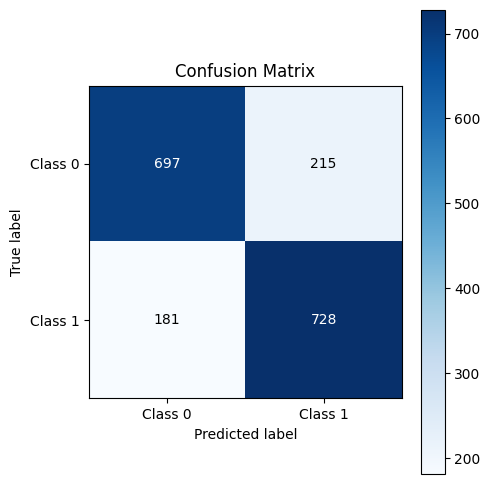

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

probs = model.predict(X_test)

if probs.ndim == 2 and probs.shape[1] > 1:
    y_pred = np.argmax(probs, axis=1)
else:
    y_pred = (probs.reshape(-1) > 0.5).astype(int)

y_true = y_test

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0','Class 1'])
plt.yticks(tick_marks, ['Class 0','Class 1'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [ ]:
# Save the model to a file
model.save("1D_CNN.keras")